<a href="https://colab.research.google.com/github/Almamun001/AI-Text-Detector/blob/main/EDGE_ML_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **📌 Project Title:** Detecting AI-Generated Text Using Statistical and Linguistic Features

---
### 📄 Table of Contents:

1. [Project Objective](#objective)
2. [Dataset Description](#dataset)
3. [Preprocessing and EDA](#eda)
4. [Feature Engineering](#features)
5. [Feature Selection](#feature-selection)
6. [Modeling and Evaluation](#modeling)
7. [Model Saving](#model-saving)
8. [Conclusion and Future Work](#conclusion)

---

### 🧠 1. <a name="objective"></a> Project Objective

The goal of this project is to develop a machine learning model that can distinguish between **AI-generated** and **human-written** text.

In [ ]:
#Suppress warning messages in Python output.
import warnings
warnings.filterwarnings('ignore')

### `drive.mount('/content/drive')`

This command mounts your **Google Drive** to the Colab environment, allowing you to **read from and write to files** stored in your Drive (e.g., datasets, model files).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### `!ls "/content/drive/MyDrive/EDGE ML Course Project/"`

This shell command lists all **files and folders** inside the specified Google Drive directory.  
Useful for **verifying dataset/model paths** in Colab.


In [ ]:
!ls "/content/drive/MyDrive/EDGE ML Course Project/"

'100k Human vs AI text.csv'


### 📦 2. <a name="dataset"></a> Dataset Description

Although the full dataset contains around **500,000 essays**, this project uses a **balanced subset** of:

- **50,000 Human-written** texts  
- **50,000 AI-generated** texts  
- **Total: 100,000 samples**

This balanced dataset helps ensure **fair model training** and **unbiased evaluation** when distinguishing between human and AI text.

- Each entry in the dataset contains:
  - `text`: The full content of the essay or passage
  - `generated`: Label indicating the origin (`0.0` = Human-written, `1.0` = AI-generated)

### 🔗 Dataset Link
[AI vs Human Text Dataset – Kaggle](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data)

Duplicates were removed during preprocessing to maintain data quality.


In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/EDGE ML Course Project/100k Human vs AI text.csv"
df = pd.read_csv(path)

In [ ]:
# 4) Quick sanity check
print("Shape:", df.shape)
print(df.columns)
df.head()

Shape: (100000, 2)
Index(['text', 'generated'], dtype='object')


,text,generated
0,"Hey, Mrs. Johnson! Here's my essay on the impo...",1.0
1,"Dear Principal [Last Name],\n\nI am writing to...",1.0
2,Venus is a planet that is a sister to our plan...,0.0
3,Technology has had a significant impact on on...,1.0
4,"Dear Senator,\n\nI am writing to you today to ...",1.0


### 🧹 3. <a name="eda"></a> Preprocessing and EDA

* Removed:

  * Missing values (none detected), If there was any missing values, we would remove those rows that have missing values.
  * More then 10k Duplicates are removed.
* Class distribution visualized:

  * Rough balance between AI and human text

Text statistics were also explored:

* `char_count`: Total characters
* `word_count`: Total words
* Histograms were plotted per class

---

In [ ]:
# Count missing values per column
print(df.isnull().sum())

# Count exact duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Peek at any duplicates
df[df.duplicated(keep=False)].head(10)


text         0
generated    0
dtype: int64
Duplicate rows: 10008


,text,generated
2,Venus is a planet that is a sister to our plan...,0.0
4,"Dear Senator,\n\nI am writing to you today to ...",1.0
6,"\n\nIn any democratic nation, it's crucial for...",1.0
10,Most schools have always been about students b...,0.0
11,I am about to tell you about TSE best job ever...,0.0
14,The face on Mars has been said to be created b...,0.0
15,**Introduction**\n\nHave you ever wanted to be...,1.0
16,"In ""The Challenge of Exploring Venus,"" the aut...",0.0
20,Meditation and mindfulness practices are becom...,1.0
22,"Diary Senator,\n\nI am writing to you today to...",1.0


In [ ]:
# Drop duplicate rows in-place
df.drop_duplicates(inplace=True)

# Check how many were removed
print("Shape after dropping duplicates:", df.shape)


Shape after dropping duplicates: (89992, 2)


generated
Human-written    46258
AI-generated     43734
Name: count, dtype: int64


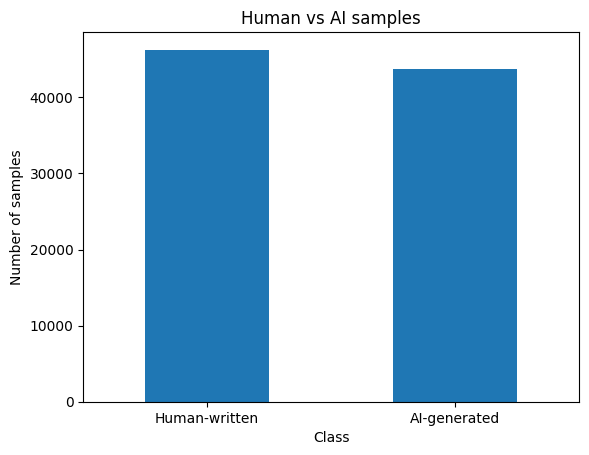

In [ ]:
# `df` is your DataFrame after dropping duplicates
counts = df['generated'].value_counts().rename(index={0.0:'Human-written', 1.0:'AI-generated'})
print(counts)

# For a quick bar chart:
import matplotlib.pyplot as plt
counts.plot(kind='bar')
plt.title("Human vs AI samples")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.show()


The data is already quite balanced. So there is no need to balance the dataset.  
If there was imbalanced data, we could balance it using data balancing techniques like:

1. Random Oversampling: Increases samples of the minority class by duplicating them.

2. Random Undersampling: Reduces the majority class by randomly removing some samples.

3. SMOTE (Synthetic Minority Over-sampling Technique): Creates synthetic examples for the minority class using interpolation.

4. ADASYN (Adaptive Synthetic Sampling): Similar to SMOTE, but generates more synthetic data for harder-to-learn examples.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute length features
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Summary statistics by class
summary = (
    df
    .groupby('generated')[['char_count', 'word_count']]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)
summary['generated'] = summary['generated'].map({0.0: 'Human-written', 1.0: 'AI-generated'})
summary.columns = [
    'Class', 'Char Mean', 'Char Median', 'Char Std', 'Char Min', 'Char Max',
    'Word Mean', 'Word Median', 'Word Std', 'Word Min', 'Word Max'
]
print(summary)

           Class    Char Mean  Char Median     Char Std  Char Min  Char Max  \
0  Human-written  2360.505556       2155.0  1091.665705       239      9157   
1   AI-generated  2123.080875       2048.0   784.147038        19      8104   

    Word Mean  Word Median    Word Std  Word Min  Word Max  
0  422.960396        389.0  188.530359        48      1650  
1  343.906983        337.0  116.651356         2      1145  


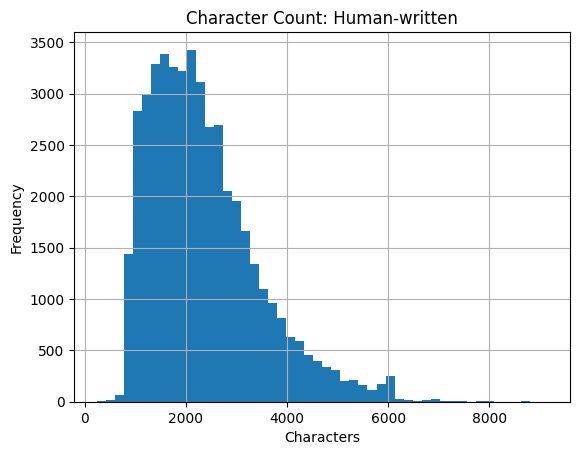

In [ ]:
# Histograms
# Character Count: Human-written

plt.figure()
df[df['generated']==0]['char_count'].hist(bins=50)
plt.title("Character Count: Human-written")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

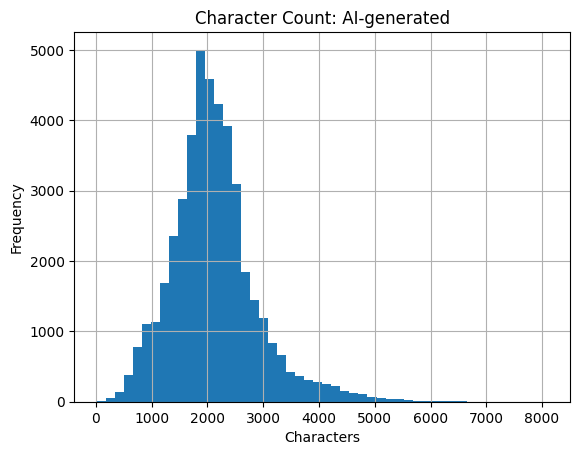

In [ ]:
# Character Count: AI-generated
plt.figure()
df[df['generated']==1]['char_count'].hist(bins=50)
plt.title("Character Count: AI-generated")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

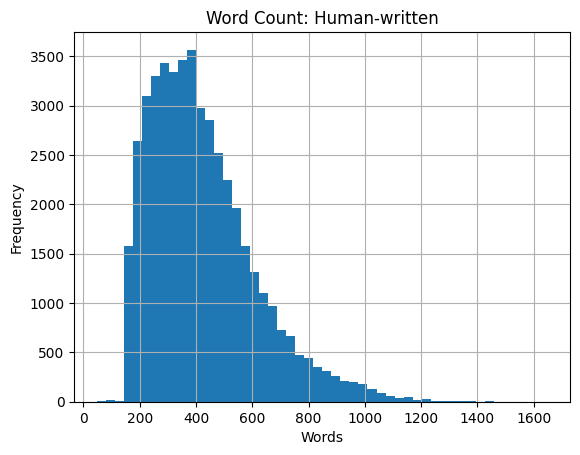

In [ ]:
# Word Count: Human-written
plt.figure()
df[df['generated']==0]['word_count'].hist(bins=50)
plt.title("Word Count: Human-written")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

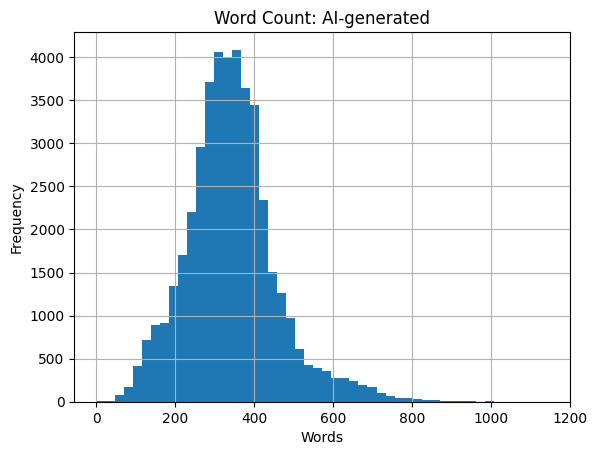

In [ ]:
# Word Count: AI-generated
plt.figure()
df[df['generated']==1]['word_count'].hist(bins=50)
plt.title("Word Count: AI-generated")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### 📦 Library Usage (Brief)

- `pandas`: For loading and manipulating dataset (`DataFrame`, CSV reading).
- `re`: For text pattern matching (e.g., sentence splitting, URL detection).
- `string`: For accessing punctuation and other character sets.
- `sklearn.feature_extraction.text.ENGLISH_STOP_WORDS`: For removing common English stopwords during text preprocessing.


In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

### 🛠️ 4. <a name="features"></a> Feature Engineering

Linguistic and statistical features extracted from text:

| Feature                                                         | Description                |
| --------------------------------------------------------------- | -------------------------- |
| `char_count`                                                    | Total characters           |
| `word_count`                                                    | Total words                |
| `punct_count`, `exclam_count`, `quest_count`                    | Punctuation usage          |
| `stopword_ratio`                                                | Stopwords / total words    |
| `avg_word_len`                                                  | Average length of words    |
| `digit_ratio`, `upper_ratio`                                    | Character-level metrics    |
| `flesch_reading_ease`, `flesch_kincaid_grade`                   | Readability scores         |
| `lexical_diversity`                                             | Unique words / total words |
| `url_count`, `mention_count`, `hashtag_count`, `html_tag_count` | Social media indicators    |

Density plots were used to compare distribution by class.

---

In [ ]:
# Feature-engineering helper functions
def count_syllables_in_word(word):
    """
    Counts the number of syllables in a given English word using a simple heuristic.

    Parameters:
        word (str): The word for which to count syllables.

    Returns:
        int: The estimated number of syllables in the word.
    """
    word = word.lower()
    vowels = "aeiouy"
    syllable_count = 0
    prev_char_was_vowel = False
    for char in word:
        is_vowel = char in vowels
        if is_vowel and not prev_char_was_vowel:
            syllable_count += 1
        prev_char_was_vowel = is_vowel
    if word.endswith("e"):
        syllable_count = max(1, syllable_count - 1)
    return syllable_count

In [ ]:
def flesch_reading_ease(text):
    """
    Calculate the Flesch Reading Ease score for the given text.

    Formula:
    206.835 - 1.015 * (average words per sentence) - 84.6 * (average syllables per word)

    Parameters:
        text (str): The input text string to analyze.

    Returns:
        float: The Flesch Reading Ease score rounded to 2 decimal places.
    """
    sentences = re.split(r'[.!?]+', text)
    sentences = [s for s in sentences if s.strip()]
    num_sentences = max(len(sentences), 1)
    words = re.findall(r'\w+', text)
    num_words = max(len(words), 1)
    syllables = sum(count_syllables_in_word(w) for w in words)
    return round(206.835 - 1.015 * (num_words / num_sentences) - 84.6 * (syllables / num_words), 2)

In [ ]:
def flesch_kincaid_grade(text):
    """
    Calculate the Flesch-Kincaid Grade Level for the given text.

    Formula:
    0.39 * (average words per sentence) + 11.8 * (average syllables per word) - 15.59

    Parameters:
        text (str): The input text string to analyze.

    Returns:
        float: The Flesch-Kincaid Grade Level rounded to 2 decimal places.
    """
    sentences = re.split(r'[.!?]+', text)
    sentences = [s for s in sentences if s.strip()]
    num_sentences = max(len(sentences), 1)
    words = re.findall(r'\w+', text)
    num_words = max(len(words), 1)
    syllables = sum(count_syllables_in_word(w) for w in words)
    return round(0.39 * (num_words / num_sentences) + 11.8 * (syllables / num_words) - 15.59, 2)

In [ ]:
# Extract Features
df['punct_count']       = df['text'].apply(lambda s: len([c for c in s if c in string.punctuation]))  # Count punctuation characters
df['exclam_count']      = df['text'].apply(lambda s: s.count('!'))  # Count exclamation marks
df['quest_count']       = df['text'].apply(lambda s: s.count('?'))  # Count question marks

df['stopword_ratio']    = df['text'].apply(lambda s: sum(1 for w in re.findall(r'\w+', s.lower()) if w in stop_words) / max(len(re.findall(r'\w+', s)), 1))  # Ratio of stopwords to total words
df['avg_word_len']      = df['text'].apply(lambda s: sum(len(w) for w in re.findall(r'\w+', s)) / max(len(re.findall(r'\w+', s)), 1))  # Average word length
df['digit_ratio']       = df['text'].apply(lambda s: sum(c.isdigit() for c in s) / max(len(s), 1))  # Ratio of digit characters
df['upper_ratio']       = df['text'].apply(lambda s: sum(1 for c in s if c.isupper()) / max(len(s), 1))  # Ratio of uppercase letters

df['flesch_reading_ease']  = df['text'].apply(flesch_reading_ease)  # Compute Flesch Reading Ease score
df['flesch_kincaid_grade'] = df['text'].apply(flesch_kincaid_grade)  # Compute Flesch-Kincaid Grade level

df['lexical_diversity'] = df['text'].apply(lambda s: len(set(re.findall(r'\w+', s.lower()))) / max(len(re.findall(r'\w+', s)), 1))  # Ratio of unique words to total words

df['url_count']         = df['text'].apply(lambda s: len(re.findall(r'https?://\S+|www\.\S+', s)))  # Count URLs in text
df['mention_count']     = df['text'].apply(lambda s: len(re.findall(r'@\w+', s)))  # Count mentions (@username)
df['hashtag_count']     = df['text'].apply(lambda s: len(re.findall(r'#\w+', s)))  # Count hashtags (#topic)
df['html_tag_count']    = df['text'].apply(lambda s: len(re.findall(r'<[^>]+>', s)))  # Count HTML tags

# Optional: View sample
df[['punct_count','exclam_count','quest_count','stopword_ratio','avg_word_len',
    'digit_ratio','upper_ratio','flesch_reading_ease','flesch_kincaid_grade',
    'lexical_diversity','url_count','mention_count','hashtag_count','html_tag_count']].head()

,punct_count,exclam_count,quest_count,stopword_ratio,avg_word_len,digit_ratio,upper_ratio,flesch_reading_ease,flesch_kincaid_grade,lexical_diversity,url_count,mention_count,hashtag_count,html_tag_count
0,103,3,3,0.543243,4.048649,0.000000,0.019507,85.74,3.85,0.337838,0,0,0,0
1,40,0,0,0.523511,5.075235,0.000000,0.013111,46.04,11.79,0.413793,0,0,0,0
2,24,0,0,0.518160,4.292978,0.001812,0.030797,57.62,13.11,0.435835,0,0,0,0
3,31,0,0,0.509225,5.033210,0.000000,0.010210,42.65,12.12,0.442804,0,0,0,0
4,49,0,0,0.476190,4.932773,0.005977,0.028966,43.68,11.02,0.414566,0,0,0,0


### Visualization of Feature Distributions

- Used **Seaborn** to create Kernel Density Estimate (KDE) plots for each engineered feature.
- Compared distributions of features between **Human-written** and **AI-generated** texts.
- Visualized features like punctuation, stopword ratio, readability scores, lexical diversity, and social media markers.
- These plots help identify which features differ notably between the two classes, aiding feature selection and model interpretation.


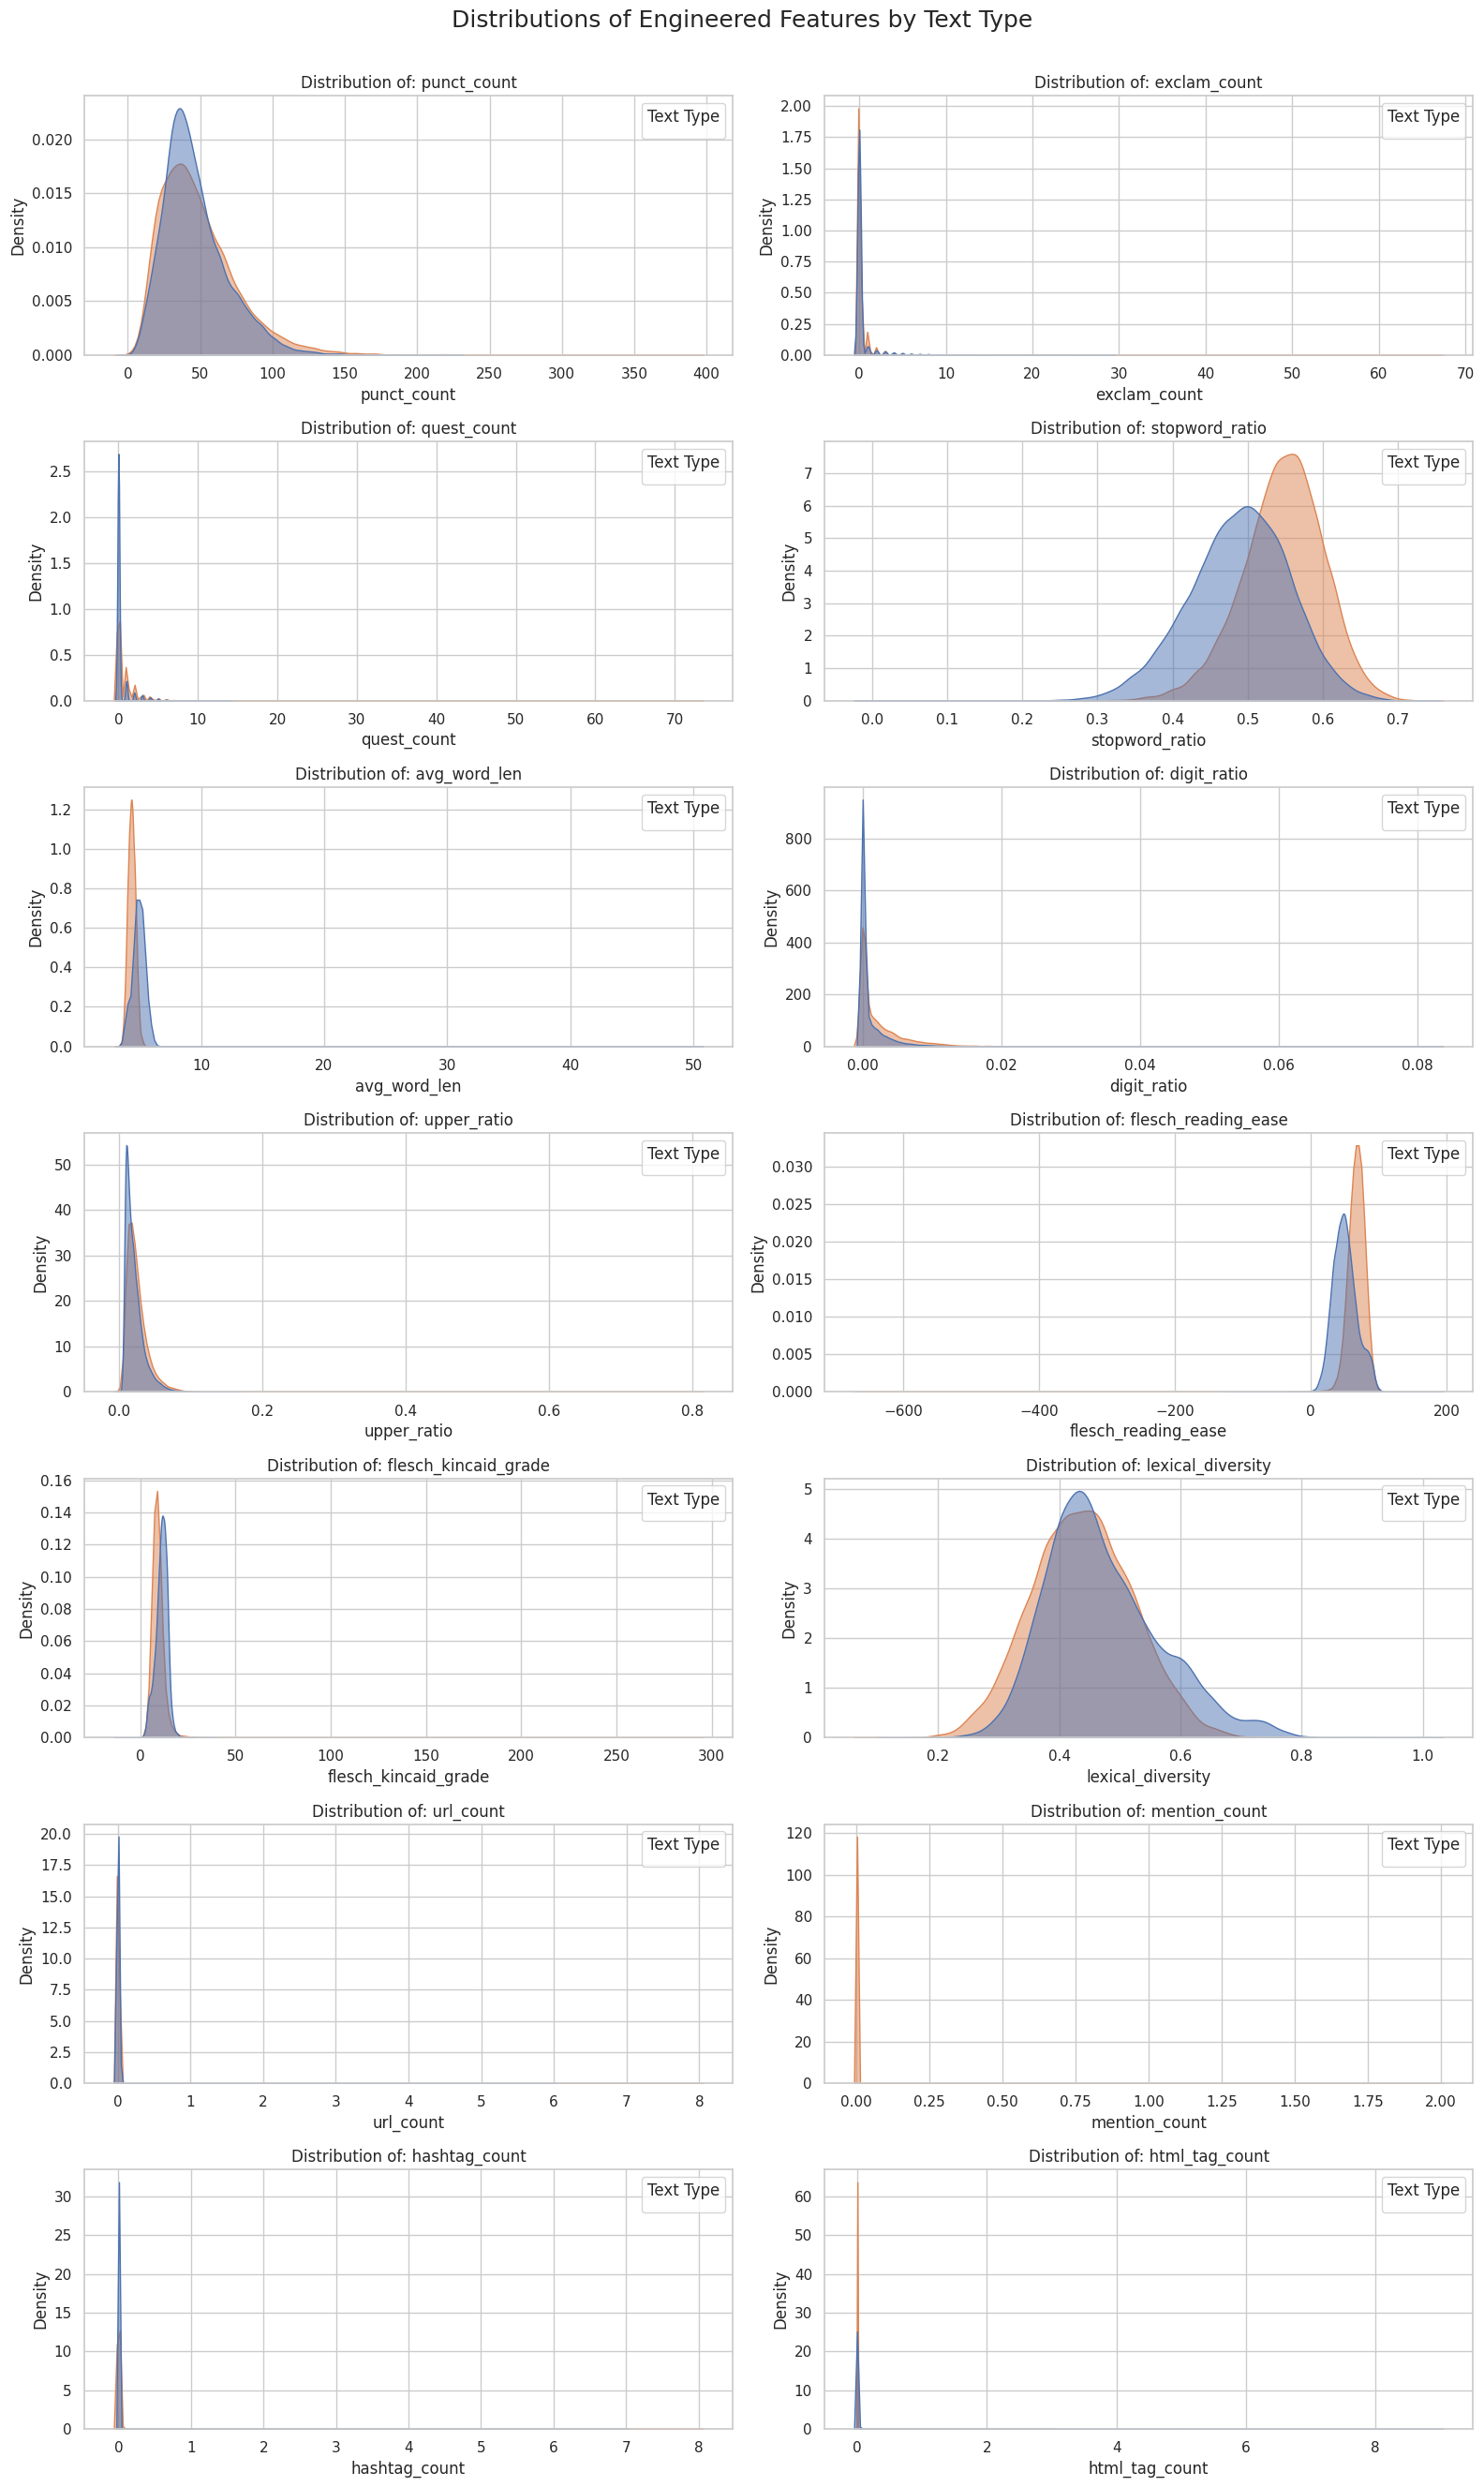

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Features to analyze
feature_cols = [
    'punct_count', 'exclam_count', 'quest_count', 'stopword_ratio', 'avg_word_len',
    'digit_ratio', 'upper_ratio', 'flesch_reading_ease', 'flesch_kincaid_grade',
    'lexical_diversity', 'url_count', 'mention_count', 'hashtag_count', 'html_tag_count'
]

# Map labels for readability
df['label'] = df['generated'].map({0.0: 'Human', 1.0: 'AI'})

# Create a grid of KDE plots for each feature
plt.figure(figsize=(16, 26))
for i, col in enumerate(feature_cols):
    plt.subplot(7, 2, i + 1)
    sns.kdeplot(data=df, x=col, hue='label', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of: {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend(title='Text Type')
    plt.tight_layout()

plt.suptitle("Distributions of Engineered Features by Text Type", fontsize=18, y=1.02)
plt.show()


### Feature Normalization

- Used `MinMaxScaler` from `sklearn.preprocessing` to scale all selected features between **0 and 1**.
- Normalization ensures all features are on the same scale, improving model training stability and performance.
- Applied scaling to features like punctuation counts, readability scores, lexical diversity, and social media counts.
- Displayed the first few rows of the normalized features to verify the transformation.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the feature columns to normalize
feature_cols = [
    'punct_count', 'exclam_count', 'quest_count', 'stopword_ratio', 'avg_word_len',
    'digit_ratio', 'upper_ratio', 'flesch_reading_ease', 'flesch_kincaid_grade',
    'lexical_diversity', 'url_count', 'mention_count', 'hashtag_count', 'html_tag_count'
]

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[feature_cols].head()

,punct_count,exclam_count,quest_count,stopword_ratio,avg_word_len,digit_ratio,upper_ratio,flesch_reading_ease,flesch_kincaid_grade,lexical_diversity,url_count,mention_count,hashtag_count,html_tag_count
0,0.265464,0.044776,0.041096,0.733158,0.021299,0.000000,0.024164,0.879582,0.054180,0.271791,0.0,0.0,0.0,0.0
1,0.103093,0.000000,0.000000,0.706527,0.042882,0.000000,0.016241,0.833129,0.080111,0.355322,0.0,0.0,0.0,0.0
2,0.061856,0.000000,0.000000,0.699305,0.026436,0.021844,0.038149,0.846679,0.084422,0.379563,0.0,0.0,0.0,0.0
3,0.079897,0.000000,0.000000,0.687247,0.041998,0.000000,0.012648,0.829162,0.081189,0.387227,0.0,0.0,0.0,0.0
4,0.126289,0.000000,0.000000,0.642664,0.039887,0.072071,0.035880,0.830367,0.077596,0.356172,0.0,0.0,0.0,0.0


---

### 🎯 5. <a name="feature-selection"></a> Feature Selection

* Normalized features using `MinMaxScaler`
* Selected top features using `SelectKBest(f_classif)`
* Chosen top 10 based on F-score:

  * `avg_word_len`, `stopword_ratio`, `flesch_reading_ease`, `digit_ratio`, `lexical_diversity`, `quest_count`, `upper_ratio`, `punct_count`, `exclam_count`, `flesch_kincaid_grade`

---

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target
X = df[feature_cols]
y = df['generated']

# Select top features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Store scores in a DataFrame
scores_df = pd.DataFrame({
    'Feature': feature_cols,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values(by='F-Score', ascending=False)

# Show results
scores_df.reset_index(drop=True, inplace=True)
scores_df


,Feature,F-Score,P-Value
0,avg_word_len,36264.724858,0.000000e+00
1,stopword_ratio,20307.661080,0.000000e+00
2,flesch_reading_ease,19610.072853,0.000000e+00
3,digit_ratio,3762.605507,0.000000e+00
4,lexical_diversity,3279.593468,0.000000e+00
5,flesch_kincaid_grade,2861.602128,0.000000e+00
6,quest_count,2576.247485,0.000000e+00
7,upper_ratio,1183.380860,1.188153e-257
8,punct_count,237.420576,1.681156e-53
9,exclam_count,224.107421,1.322883e-50


### Feature Correlation Heatmap

- Visualizes the pairwise correlations between all engineered features.
- Uses a color gradient (`coolwarm`) to indicate strength and direction of correlation.
- Helps identify strongly correlated features that might be redundant.
- Useful for feature selection and understanding feature relationships before modeling.


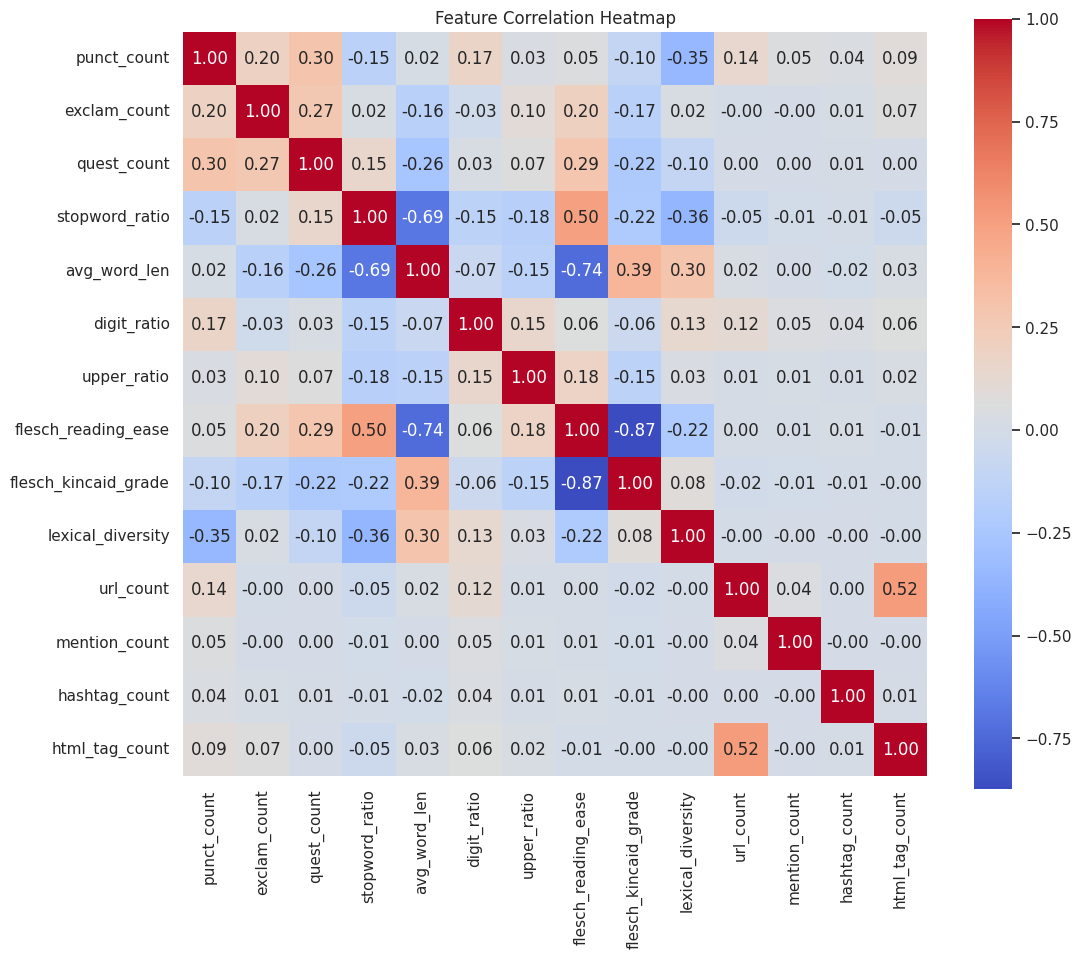

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


### Feature Selection Approach

- **Top 10 features were manually selected (hardcoded)** based on their ANOVA F-scores and domain knowledge.
- These features showed the strongest statistical association with the target class and meaningful interpretability.

### Alternative Feature Selection Methods

1. **Univariate Feature Selection:**  
   Select features based on individual statistical tests (e.g., `SelectKBest` with ANOVA F-test).

2. **Recursive Feature Elimination (RFE):**  
   Iteratively remove least important features based on model weights.

3. **Embedded Methods:**  
   Use models with built-in feature selection like Lasso or tree-based algorithms.

4. **Feature Importance from Tree Models:**  
   Rank features by importance scores from Random Forest or XGBoost.

5. **Dimensionality Reduction:**  
   Use PCA to combine features into fewer informative components.

6. **Correlation Thresholding:**  
   Remove highly correlated features to reduce redundancy.

7. **Domain Knowledge:**  
   Incorporate expert insights and data exploration to guide selection.

These methods can help automate and optimize the feature selection process.


In [ ]:
selected_features = [
    'avg_word_len',
    'stopword_ratio',
    'flesch_reading_ease',
    'digit_ratio',
    'lexical_diversity',
    'quest_count',
    'upper_ratio',
    'punct_count',
    'exclam_count',
    'flesch_kincaid_grade'
]

### Importing Key Libraries for Model Preparation

- `train_test_split` from `sklearn.model_selection`:  
  Used to split the dataset into training and testing sets in a stratified manner to preserve class distribution.

- `TfidfVectorizer` from `sklearn.feature_extraction.text`:  
  Converts raw text into TF-IDF weighted features, capturing the importance of words and phrases in the text corpus.

- `hstack` from `scipy.sparse`:  
  Efficiently combines sparse matrices (like TF-IDF vectors) with dense feature arrays, allowing integration of text and engineered numerical features for modeling.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

1. **Separate Features and Target**  
   - `X_text`: Raw text data  
   - `X_structured`: Selected engineered numerical features  
   - `y`: Target labels indicating human or AI text

In [ ]:
# Step 1: Separate features
X_text = df['text']
X_structured = df[selected_features]
y = df['generated']

2. **Train-Test Split**  
   - Split data into training (80%) and testing (20%) sets  
   - Use stratified sampling to maintain class balance

In [ ]:
# Step 2: Train-test split
X_text_train, X_text_test, X_structured_train, X_structured_test, y_train, y_test = train_test_split(
    X_text, X_structured, y, test_size=0.2, random_state=42, stratify=y
)

3. **TF-IDF Vectorization**  
   - Convert raw text to TF-IDF features capturing word importance  
   - Use unigrams and bigrams, max 10,000 features, remove English stopwords

In [ ]:
# Step 3: TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_test = tfidf.transform(X_text_test)

4. **Combine Features**  
   - Horizontally stack TF-IDF sparse matrix with dense engineered features  
   - Resulting combined feature matrix used for model training and evaluation

In [ ]:
# Step 4: Combine TF-IDF with engineered features
X_train_combined = hstack([X_tfidf_train, X_structured_train.values])
X_test_combined = hstack([X_tfidf_test, X_structured_test.values])


5. **Output Shapes**  
   - Print feature counts and combined dataset dimensions for confirmation

In [ ]:
# Output shape info
print("TF-IDF features:", X_tfidf_train.shape[1])
print("Engineered features:", X_structured_train.shape[1])
print("Combined training shape:", X_train_combined.shape)
print("Combined testing shape:", X_test_combined.shape)

TF-IDF features: 10000
Engineered features: 10
Combined training shape: (71993, 10010)
Combined testing shape: (17999, 10010)


### 🤖 6. <a name="modeling"></a> Modeling and Evaluation

Combined structured features + TF-IDF vectors:

* **Text**: Transformed using `TfidfVectorizer` (max 10,000 features, n-grams 1-2)
* **Structured features**: 10 selected linguistic/statistical features

Train-test split: 80-20 stratified.

Four models trained:

| Model               | Notes                   |
| ------------------- | ----------------------- |
| Logistic Regression | Baseline                |
| Random Forest       | Tree ensemble           |

Each model’s confusion matrix was plotted for visual comparison.

---


### Logistic Regression Model Training and Evaluation

1. **Model Training:**  
   - Trained a Logistic Regression classifier with a maximum of 1000 iterations and the 'liblinear' solver on the combined TF-IDF and engineered features.

2. **Prediction:**  
   - Generated predictions on the test dataset.

3. **Performance Metrics:**  
   - Printed a detailed classification report including precision, recall, F1-score, and support for both classes ("Human" and "AI").

4. **Confusion Matrix:**  
   - Visualized the confusion matrix using a blue color map to show true positives, false positives, true negatives, and false negatives, helping interpret model performance.


📊 Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99      9252
          AI       0.99      0.98      0.99      8747

    accuracy                           0.99     17999
   macro avg       0.99      0.99      0.99     17999
weighted avg       0.99      0.99      0.99     17999



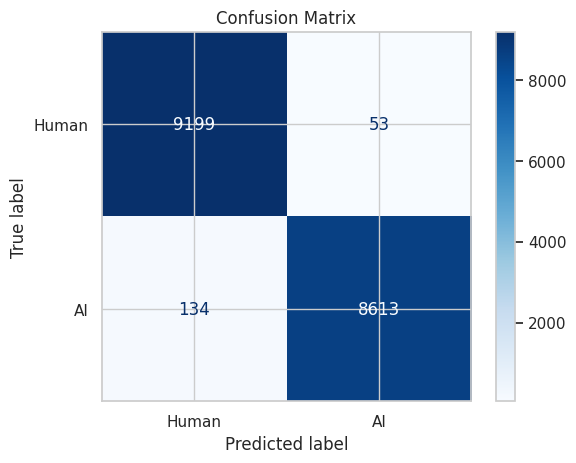

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Train the model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_combined, y_train)

# Step 2: Make predictions
y_pred = model.predict(X_test_combined)

# Step 3: Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))

# Step 4: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Random Forest Model Training and Evaluation

1. **Model Training:**  
   - Trained a Random Forest classifier with 100 trees (`n_estimators=100`) and a fixed random seed (`random_state=42`) on the combined features.

2. **Prediction:**  
   - Predicted labels for the test dataset.

3. **Performance Metrics:**  
   - Displayed the classification report including precision, recall, F1-score, and support for both classes ("Human" and "AI").

4. **Confusion Matrix:**  
   - Visualized the confusion matrix with a blue color scheme to analyze the model’s correct and incorrect predictions.


📊 Random Forest Classification Report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      9252
          AI       1.00      0.99      0.99      8747

    accuracy                           0.99     17999
   macro avg       0.99      0.99      0.99     17999
weighted avg       0.99      0.99      0.99     17999



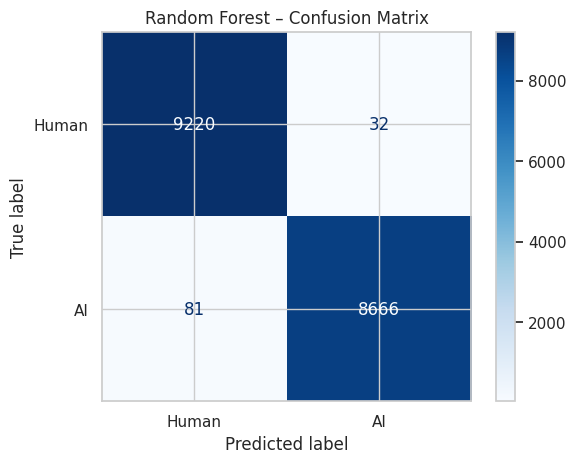

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_combined)

# Evaluate
print("📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Human", "AI"]))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Human", "AI"])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest – Confusion Matrix")
plt.show()


### 💾 7. <a name="model-saving"></a> Model Saving
---
Saving Trained Models

- Used `joblib` to serialize and save trained models to Google Drive.
- Saved the **Random Forest** model as `random_forest_model.pkl`.
- Saved the **Logistic Regression** model as `logistic_regression_model.pkl`.
- Saving models allows for later reuse without retraining, facilitating deployment or further analysis.

Saved trained models to disk using `joblib`:

* `random_forest_model.pkl`
* `logistic_regression_model.pkl`


In [ ]:
import joblib

save_path = "/content/drive/MyDrive/EDGE ML Course Project/"

# Save each model with clear names
joblib.dump(rf_model, save_path + 'random_forest_model.pkl')
joblib.dump(model, save_path + 'logistic_regression_model.pkl')

['/content/drive/MyDrive/EDGE ML Course Project/logistic_regression_model.pkl']

### Model Performance Comparison

- Calculated **Accuracy** and **F1 Score** for each model on the test set.
- Compared Logistic Regression and Random Forest classifiers using these metrics.
- Results are presented in a sorted table by F1 Score for easy comparison.
- Helps identify the best-performing model based on balanced precision and recall.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = []

# Logistic Regression
y_pred_lr = model.predict(X_test_combined)
results.append({
    "Model": "Logistic Regression",
    "Accuracy": round(accuracy_score(y_test, y_pred_lr), 4),
    "F1 Score": round(f1_score(y_test, y_pred_lr), 4)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Accuracy": round(accuracy_score(y_test, y_pred_rf), 4),
    "F1 Score": round(f1_score(y_test, y_pred_rf), 4)
})

# Create and display results table
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("📊 Model Comparison:")
print(results_df)

📊 Model Comparison:
                 Model  Accuracy  F1 Score
1        Random Forest    0.9937    0.9935
0  Logistic Regression    0.9896    0.9893


### 🧭 8. <a name="conclusion"></a> Conclusion and Future Work

**Findings**:

* Statistical and readability features combined with TF-IDF lead to strong classification performance.
* Random Forest outperforms Logistic Regression due to its robustness in mixed feature domains.

**Future Enhancements:**

- Extend the model to support detection in languages other than English.
- Incorporate deep learning models (e.g., BERT) for improved semantic understanding and context awareness.
- Augment the dataset with adversarial examples to increase robustness.
- Implement model interpretability techniques such as SHAP or LIME to better explain predictions.


---


#Thank you for reviewing this project.
#Your feedback and suggestions are greatly appreciated.

